In [2]:
# notebook last tested with abtem version 1.0.0beta13

from abtem import __version__
print('current version:', __version__)

from ase.io import read
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from abtem import *

current version: 1.0.0beta13


# PACBED thickness series

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

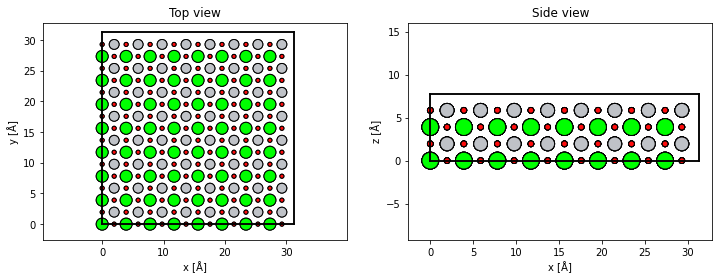

In [3]:
atoms = read('../data/srtio3_100.cif')

atoms *= (8, 8, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [4]:
potential = Potential(atoms, 
                      gpts=512, 
                      device='gpu', 
                      projection='infinite', 
                      slice_thickness=.5, 
                      parametrization='kirkland', 
                      storage='gpu').build(pbar=True)

In [5]:
detector = PixelatedDetector(max_angle=10)

end = (potential.extent[0] / 8, potential.extent[1] / 8)

scan = GridScan(start=[0, 0], end=end, sampling=.2)

probe = Probe(energy=300e3, semiangle_cutoff=9.4, device='gpu', rolloff=0.05)

probe.grid.match(potential)

measurements = [detector.allocate_measurement(probe) for i in range(30)]

In [6]:
for indices, positions in scan.generate_positions(max_batch=20, pbar=True):
    probes = probe.build(positions)
    
    for measurement in measurements:
        probes = probes.multislice(potential, pbar=False)
        
        measurement += detector.detect(probes).sum(0)

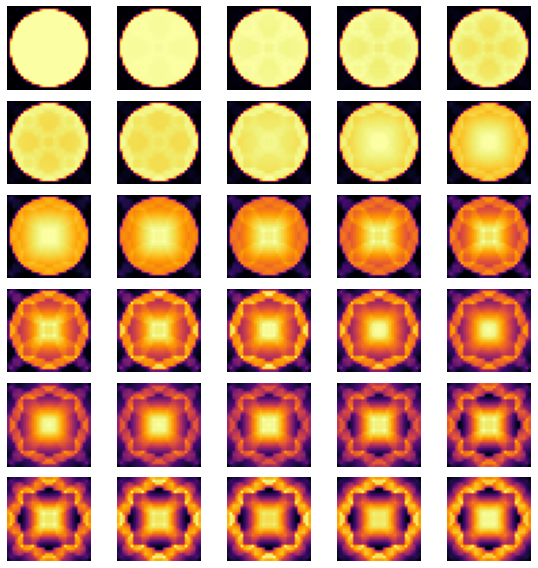

In [7]:
fig, axes = plt.subplots(6,5, figsize=(8,8))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(measurements[i].array, cmap='inferno')
    ax.axis('off')

plt.tight_layout()